<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/roccos-fun-branch/RNN_Acc_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Colab Mount

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display


from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Function Definitions

In [66]:
# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  train_data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_10s_3classes_npy/train', loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_10s_3classes_npy/validation', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.squeeze().float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

## Base Arch

In [52]:
class AccClassRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, batch_size, name):
    super(AccClassRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.batch_size = batch_size
    self.name = "AccClassRNN_" + name

  def forward(self, x):
    # Look up the embedding
    #print(x)
    #print(x.shape)
    #print(x.transpose(1,2).shape)
    #x = np.multiply(self.ident, x)
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

## Data Gen

Array shape is (27, 1, 13, 431)
13


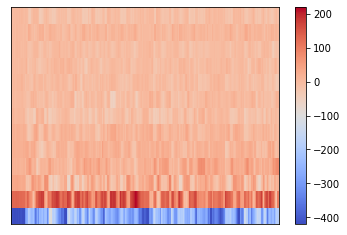

In [57]:
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

## Train Func

In [68]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.squeeze().float().cuda().transpose(1,2)
            # print(input_array.shape)
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_rnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%25==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
          plot_graphs(iters, losses, [], train_acc, val_acc)
    
    plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

## Experiments

### Exp 1: Base

Using CUDA
Epoch:  0 Train Accuracy:  0.3442265795206972 Val Accuracy:  0.3333333333333333 Progress:   3.33  % Time Elapsed:   6.53 s 
Epoch 0 Finished.  Time per Epoch:   6.53 s 
Epoch:  1 Train Accuracy:  0.4117647058823529 Val Accuracy:  0.42592592592592593 Progress:   6.67  % Time Elapsed:  13.05 s 
Epoch 1 Finished.  Time per Epoch:   6.52 s 
Epoch:  2 Train Accuracy:  0.48366013071895425 Val Accuracy:  0.48148148148148145 Progress:  10.00  % Time Elapsed:  19.13 s 
Epoch 2 Finished.  Time per Epoch:   6.38 s 
Epoch:  3 Train Accuracy:  0.47276688453159044 Val Accuracy:  0.4444444444444444 Progress:  13.33  % Time Elapsed:  25.22 s 
Epoch 3 Finished.  Time per Epoch:   6.31 s 
Epoch:  4 Train Accuracy:  0.5228758169934641 Val Accuracy:  0.4444444444444444 Progress:  16.67  % Time Elapsed:  31.29 s 
Epoch 4 Finished.  Time per Epoch:   6.26 s 
Epoch:  5 Train Accuracy:  0.5185185185185185 Val Accuracy:  0.42592592592592593 Progress:  20.00  % Time Elapsed:  37.45 s 
Epoch 5 Finishe

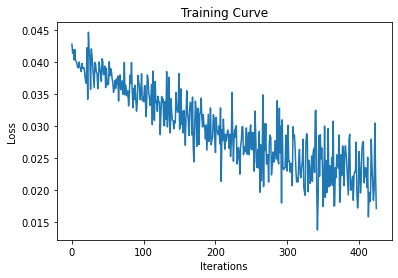

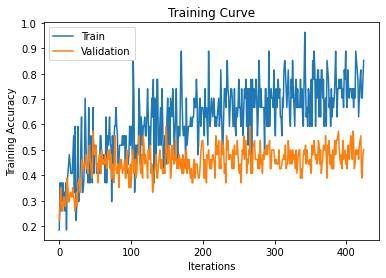

Epoch:  25 Train Accuracy:  0.7647058823529411 Val Accuracy:  0.3888888888888889 Progress:  86.67  % Time Elapsed:  160.19 s 
Epoch 25 Finished.  Time per Epoch:   6.16 s 
Epoch:  26 Train Accuracy:  0.7668845315904139 Val Accuracy:  0.4074074074074074 Progress:  90.00  % Time Elapsed:  166.25 s 
Epoch 26 Finished.  Time per Epoch:   6.16 s 
Epoch:  27 Train Accuracy:  0.7559912854030502 Val Accuracy:  0.46296296296296297 Progress:  93.33  % Time Elapsed:  172.35 s 
Epoch 27 Finished.  Time per Epoch:   6.16 s 
Epoch:  28 Train Accuracy:  0.7734204793028322 Val Accuracy:  0.5740740740740741 Progress:  96.67  % Time Elapsed:  178.47 s 
Epoch 28 Finished.  Time per Epoch:   6.15 s 
Epoch:  29 Train Accuracy:  0.7843137254901961 Val Accuracy:  0.48148148148148145 Progress:  100.00  % Time Elapsed:  184.47 s 
Epoch 29 Finished.  Time per Epoch:   6.15 s 


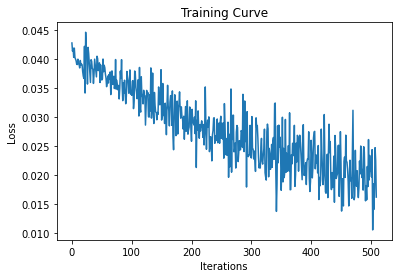

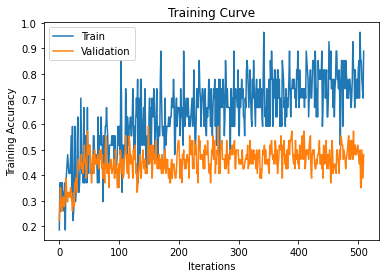

Finished Training
Total time:   184.87 s  Time per Epoch:   6.16 s 


In [70]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 50
learning_rate = 0.001
hidden_size = 20
num_classes = 3
name = "base_RNN"
acc_net = AccClassRNN(mfcc_bands, hidden_size, num_classes , batch_size, name)
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = 30)
#train_rnn_network(acc_net, train_data, val_data, batch_size = 27, learning_rate = learning_rate, num_epochs = num_epochs)

#lstm = LSTM(mfcc_bands, hidden_size, num_classes)
#train_net(lstm, batch_size = 27, learning_rate = 0.001, num_epochs = 30)